# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:
# ============================================================
# LOAD AND PREVIEW DATA
# Loading the vehicle dataset (426K records) and displaying a random sample
# to understand the data structure and available features.
# ============================================================

import pandas as pd

vehicles = pd.read_csv('./data/vehicles.csv')
print(vehicles.sample(5))

                id                    region  price    year manufacturer  \
44210   7315446814              palm springs  69800  2017.0         ford   
179158  7312279758                     maine   6300  2007.0         mini   
77510   7315547106                    denver   4400  2009.0         ford   
296436  7311522547                  columbus  11995  2011.0         ford   
403087  7313898240  kennewick-pasco-richland  16994  2017.0       subaru   

                         model  condition    cylinders    fuel  odometer  \
44210                    f-250        NaN          NaN  diesel   37887.0   
179158                cooper s  excellent  4 cylinders     gas  123000.0   
77510   expedition eddie bauer       good  8 cylinders     gas  178000.0   
296436                  escape        NaN          NaN     gas   69768.0   
403087                forester        NaN  4 cylinders     gas   90557.0   

       title_status transmission                VIN drive       size  \
44210         

In [ ]:
# ============================================================
# DATA SUMMARY
# Displays dataset structure: row count, column names, data types, and missing value counts.
# Key observation: 'condition' and 'cylinders' have significant missing values requiring imputation.
# ============================================================

vehicles.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [ ]:
<!-- 
PURPOSE: Planning feature engineering.
Creating an 'Age' column derived from vehicle year (Age = 2025 - Year).
Age is often more intuitive for analysis than raw year values.
-->

In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# COMPREHENSIVE DATA PREPROCESSING PIPELINE
# This cell performs all data cleaning and feature engineering:
# 1. Standardize manufacturer names (lowercase, fill missing)
# 2. Impute missing year/odometer values using median miles-per-year estimation
# 3. Engineer derived features (age, is_luxury, is_american, miles_per_year)
# 4. Normalize categorical values (consolidate similar labels)
# 5. Apply outlier filters (remove unrealistic prices, mileage, etc.)
# Result: Clean, analysis-ready dataset for machine learning.
# ============================================================

# ============================================================
# 0. STANDARDIZE MANUFACTURER FIELD
# Convert to lowercase for consistency; fill missing values with "unknown"
# ============================================================
vehicles['manufacturer'] = vehicles['manufacturer'].str.lower().str.strip()
vehicles['manufacturer'] = vehicles['manufacturer'].fillna('unknown')


# ============================================================
# 1. BILATERAL IMPUTATION: YEAR <-> ODOMETER
# Strategy: Use median miles-per-year to estimate missing values.
# If year is missing but odometer exists, derive year from mileage.
# If odometer is missing but year exists, derive mileage from age.
# ============================================================

# Identify rows with valid year + odometer for estimating MPY (Miles Per Year)
valid_mpy = (
    vehicles['year'].notna() &
    vehicles['odometer'].notna() &
    ((2025 - vehicles['year']) > 0)
)

# Compute median miles per year (baseline for imputation)
observed_mpy = vehicles.loc[valid_mpy, 'odometer'] / (2025 - vehicles.loc[valid_mpy, 'year'])
median_mpy = observed_mpy.median()

# ---- 1A. Estimate missing YEAR using odometer ----
# Derive model year from odometer reading and median annual mileage
missing_year_mask = (
    vehicles['year'].isna() &
    vehicles['odometer'].notna() &
    (vehicles['odometer'] > 0)
)

vehicles.loc[missing_year_mask, 'year'] = (
    2025 - (vehicles.loc[missing_year_mask, 'odometer'] / median_mpy)
).clip(1985, 2025).round()

# ---- DROP rows with missing year AND odometer = 0 ----
# Remove records where both key fields are unusable (no basis for imputation)
vehicles = vehicles[~(vehicles['year'].isna() & (vehicles['odometer'] == 0))]

# ---- 1B. Compute AGE after year is estimated ----
# Create derived feature: vehicle age in years (2025 - model year)
vehicles['age'] = 2025 - vehicles['year']
vehicles['age'] = vehicles['age'].replace([np.inf, -np.inf], np.nan)

# ---- 1C. Estimate missing ODOMETER using age ----
# Impute odometer as: age × median miles per year
missing_odo_mask = (
    vehicles['odometer'].isna() &
    vehicles['age'].notna() &
    (vehicles['age'] > 0)
)

vehicles.loc[missing_odo_mask, 'odometer'] = (
    vehicles.loc[missing_odo_mask, 'age'] * median_mpy
)

# ---- 1D. Final cleanup ----
# Fill any remaining missing values with median; apply reasonable bounds
vehicles['year'] = vehicles['year'].fillna(vehicles['year'].median())
vehicles['year'] = vehicles['year'].clip(1985, 2025)

vehicles['age'] = vehicles['age'].fillna(vehicles['age'].median())

vehicles['odometer'] = vehicles['odometer'].fillna(vehicles['age'] * median_mpy)
vehicles['odometer'] = vehicles['odometer'].clip(lower=0)


# ============================================================
# 2. MANUFACTURER FLAGS
# Create binary indicators for brand categories (luxury, American, foreign).
# These aggregate features help the model capture brand-level pricing patterns.
# ============================================================
luxury_brands = [
    'acura','alfa-romeo','aston-martin','audi','bmw','cadillac','infiniti',
    'jaguar','land rover','lexus','lincoln','mercedes-benz','porsche',
    'volvo','ferrari','mini'
]

american_brands = [
    'ford','chevrolet','gmc','jeep','ram','cadillac','buick','chrysler',
    'dodge','lincoln','tesla','mercury','saturn'
]

foreign_brands = [
    'toyota','honda','nissan','mazda','subaru','acura','hyundai','kia',
    'mitsubishi','infiniti','audi','bmw','mercedes-benz','volkswagen',
    'volvo','jaguar','land rover','porsche','alfa-romeo','fiat','mini',
    'aston-martin','ferrari','morgan','rover','datsun'
]

# Create binary (0/1) indicator columns
vehicles['is_luxury']   = vehicles['manufacturer'].isin(luxury_brands).astype(int)
vehicles['is_american'] = vehicles['manufacturer'].isin(american_brands).astype(int)
vehicles['is_foreign']  = vehicles['manufacturer'].isin(foreign_brands).astype(int)


# ============================================================
# 3. CLEAN/RECODE BASIC CATEGORIES
# Fill missing categorical values with "unknown" to prevent encoding errors.
# ============================================================

vehicles['model'] = vehicles['model'].fillna('unknown')
vehicles['fuel'] = vehicles['fuel'].fillna('unknown')
vehicles['type'] = vehicles['type'].fillna('unknown')
vehicles['drive'] = vehicles['drive'].fillna('unknown')
vehicles['paint_color'] = vehicles['paint_color'].fillna('unknown')
vehicles['title_status'] = vehicles['title_status'].fillna('unknown')
vehicles['transmission'] = vehicles['transmission'].fillna('unknown')
vehicles['condition'] = vehicles['condition'].fillna('unknown')
vehicles['cylinders'] = vehicles['cylinders'].fillna('unknown')


# ============================================================
# 4. NORMALIZE CATEGORICAL VALUES
# Consolidate similar labels and convert rare/ambiguous categories to "unknown".
# This reduces cardinality and improves model stability.
# ============================================================

# ---- condition normalization ----
# Merge semantically similar categories
vehicles['condition'] = vehicles['condition'].replace({'like new': 'excellent'})

# salvage consistency check
# Flag inconsistent salvage designations between condition and title_status
mask_salv_incon = (
    (vehicles['condition'] == 'salvage') &
    (vehicles['title_status'] != 'salvage')
)
vehicles.loc[mask_salv_incon, 'condition'] = 'unknown'
vehicles['condition'] = vehicles['condition'].replace({'salvage': 'unknown'})
# ---- Normalization for other columns ----
# Replace ambiguous labels ("other", "custom") with "unknown" to reduce cardinality

vehicles['cylinders'] = vehicles['cylinders'].replace({'other': 'unknown'})
vehicles['fuel'] = vehicles['fuel'].replace({'other': 'unknown'})
vehicles['title_status'] = vehicles['title_status'].replace({'missing': 'unknown'})
vehicles['transmission'] = vehicles['transmission'].replace({'other': 'unknown'})
vehicles['type'] = vehicles['type'].replace({'other': 'unknown', 'offroad': 'unknown'})
vehicles['paint_color'] = vehicles['paint_color'].replace({'custom': 'unknown'})

# ---- state mapping ----
# Convert state abbreviations to full names for consistency and readability
state_map = {
    'al': 'Alabama','ak': 'Alaska','az': 'Arizona','ar': 'Arkansas','ca': 'California',
    'co': 'Colorado','ct': 'Connecticut','de': 'Delaware','fl': 'Florida','ga': 'Georgia',
    'hi': 'Hawaii','id': 'Idaho','il': 'Illinois','in': 'Indiana','ia': 'Iowa','ks': 'Kansas',
    'ky': 'Kentucky','la': 'Louisiana','me': 'Maine','md': 'Maryland','ma': 'Massachusetts',
    'mi': 'Michigan','mn': 'Minnesota','ms': 'Mississippi','mo': 'Missouri','mt': 'Montana',
    'ne': 'Nebraska','nv': 'Nevada','nh': 'New Hampshire','nj': 'New Jersey','nm': 'New Mexico',
    'ny': 'New York','nc': 'North Carolina','nd': 'North Dakota','oh': 'Ohio','ok': 'Oklahoma',
    'or': 'Oregon','pa': 'Pennsylvania','ri': 'Rhode Island','sc': 'South Carolina',
    'sd': 'South Dakota','tn': 'Tennessee','tx': 'Texas','ut': 'Utah','vt': 'Vermont',
    'va': 'Virginia','wa': 'Washington','wv': 'West Virginia','wi': 'Wisconsin','wy': 'Wyoming',
    'dc': 'Virginia'
}
vehicles['state'] = vehicles['state'].map(state_map)


# ============================================================
# 5. CYLINDERS_NUM — Extract numeric value and impute by model
# Parse the numeric portion from "X cylinders" strings.
# For missing values, use the most common cylinder count for that car model.
# ============================================================

vehicles['cylinders_num'] = vehicles['cylinders'].str.extract('(\d+)').astype(float)
vehicles['cylinders_num'] = vehicles['cylinders_num'].replace(0, np.nan)

# Build lookup table: mode cylinder count per car model
model_cyl_lookup = (
    vehicles.groupby('model')['cylinders_num']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

# Impute missing cylinder counts using model-based lookup
vehicles['cylinders_num'] = vehicles.apply(
    lambda row: model_cyl_lookup[row['model']]
    if pd.isna(row['cylinders_num']) else row['cylinders_num'],
    axis=1
)

# Fallback: use overall median for remaining missing values
vehicles['cylinders_num'] = vehicles['cylinders_num'].fillna(
    vehicles['cylinders_num'].median()
)


# ============================================================
# 6. FUEL SCORE
# Create ordinal encoding for fuel type based on technology tier.
# Scale: gas=1, diesel=2, hybrid=3, electric=4, unknown=0
# ============================================================
fuel_score_map = {
    'gas': 1,'diesel': 2,'hybrid': 3,'electric': 4,'unknown': 0
}

vehicles['fuel_score'] = vehicles['fuel'].map(fuel_score_map)

vehicles = vehicles.drop(columns=['fuel_clean'], errors='ignore')


# ============================================================
# 7. MILES PER YEAR
# Purpose: Create a derived feature showing average annual usage.
# This helps distinguish heavily-used vehicles from lightly-used ones.
# ============================================================
vehicles['miles_per_year'] = vehicles['odometer'] / vehicles['age']
vehicles['miles_per_year'] = vehicles['miles_per_year'].replace([np.inf, -np.inf], np.nan)
vehicles['miles_per_year'] = vehicles['miles_per_year'].fillna(median_mpy)


# ============================================================
# 8. DROP LOW-VALUE COLUMNS
# Purpose: Remove columns that won't help the model (VIN is unique per car,
# 'size' has too many missing values to be useful).
# ============================================================
vehicles = vehicles.drop(columns=['size', 'VIN'], errors='ignore')


# ============================================================
# FINAL FILTERS — Removing Outliers and Edge Cases
# Purpose: Exclude records that fall outside reasonable ranges.
# These outliers could skew the model and don't represent typical transactions.
# ============================================================

# 1. Year filtering — Keep cars from 2000-2026 (modern vehicles only)
vehicles = vehicles[(vehicles['year'] >= 2000) & (vehicles['year'] <= 2026)]

# 2. Remove exotic cylinder counts — 10 and 12 cylinder vehicles are rare and atypical
vehicles = vehicles[~vehicles['cylinders'].isin(['10 cylinders', '12 cylinders'])]
vehicles = vehicles[~vehicles['cylinders_num'].isin([10, 12])]
vehicles = vehicles.drop(columns=['cylinders'])

# 3. Price filtering — Focus on $500-$100K range (excludes scams and supercars)
vehicles = vehicles[(vehicles['price'] >= 500) & (vehicles['price'] <= 100000)]

# 4. Odometer filtering — Keep reasonable mileage (0-225K miles)
vehicles = vehicles.query("0 < odometer <= 225000")

# 5. Miles-per-year filtering — Exclude unrealistic usage patterns
vehicles = vehicles[(vehicles['miles_per_year'] > 0) & 
                    (vehicles['miles_per_year'] <= 20000)]

# ============================================================
# DONE
# ============================================================
print("✔ FULL PREPROCESSING PIPELINE COMPLETE.")

✔ FULL PREPROCESSING PIPELINE COMPLETE.


In [ ]:
# ============================================================
# VERIFY CLEANED DATA
# Purpose: Confirm the preprocessing was successful.
# After cleaning: We should have 347K records, 22 features, and NO missing values.
# Notice: Started with 427K cars, now have 347K (removed ~80K problematic records).
# ============================================================

vehicles.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 347152 entries, 0 to 426879
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              347152 non-null  int64  
 1   region          347152 non-null  object 
 2   price           347152 non-null  int64  
 3   year            347152 non-null  float64
 4   manufacturer    347152 non-null  object 
 5   model           347152 non-null  object 
 6   condition       347152 non-null  object 
 7   fuel            347152 non-null  object 
 8   odometer        347152 non-null  float64
 9   title_status    347152 non-null  object 
 10  transmission    347152 non-null  object 
 11  drive           347152 non-null  object 
 12  type            347152 non-null  object 
 13  paint_color     347152 non-null  object 
 14  state           347152 non-null  object 
 15  age             347152 non-null  float64
 16  is_luxury       347152 non-null  int64  
 17  is_american    

In [ ]:
# ============================================================
# INSPECT CATEGORICAL COLUMNS BEFORE ONE-HOT ENCODING
# Purpose: Review all text-based (object) columns to ensure they're clean.
# Before converting categories to numbers, I need to verify:
#   - No inconsistent labels (e.g., "Ford" vs "ford" vs "FORD")
#   - No unexpected values that slipped through cleaning
#   - Reasonable number of unique values (too many = encoding problems)
# This quality check prevents encoding errors during model training.
# ============================================================

import pandas as pd

# Identify all object (categorical) columns
object_columns = vehicles.select_dtypes(include='object').columns

print("Found", len(object_columns), "object columns.\n")

# Loop through each object column and print information
for col in object_columns:
    print("=" * 60)
    print(f"Column: {col}")
    
    # Number of unique values
    unique_count = vehicles[col].nunique()
    print(f"Unique values: {unique_count}")
    
    # Display the actual unique values (first 50 so notebook doesn't explode)
    uniques = vehicles[col].unique()
    if unique_count > 50:
        print("First 50 unique values:")
        print(uniques[:50])
        print("... (truncated)")
    else:
        print("Values:")
        print(uniques)
    
    print("\n")

Found 11 object columns.

Column: region
Unique values: 404
First 50 unique values:
['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'bellingham'
 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham' 'dothan'
 'florence / muscle shoals' 'gadsden-anniston' 'huntsville / decatur'
 'mobile' 'montgomery' 'tuscaloosa' 'anchorage / mat-su' 'fairbanks'
 'kenai peninsula' 'southeast alaska' 'flagstaff / sedona' 'mohave county'
 'phoenix' 'show low' 'sierra vista' 'tucson' 'yuma' 'fort smith'
 'jonesboro' 'little rock' 'texarkana' 'bakersfield' 'chico'
 'fresno / madera' 'gold country' 'hanford-corcoran' 'humboldt county'
 'imperial county' 'inland empire' 'los angeles' 'mendocino county'
 'merced' 'modesto' 'monterey bay' 'orange county' 'palm springs']
... (truncated)


Column: manufacturer
Unique values: 42
Values:
['unknown' 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## Exploratory Data Visualization: Feature Correlations with Price

<!-- 
Purpose: Before building models, visualize how each feature relates to price.
This helps identify which variables have strong relationships with price
and informs feature selection decisions.
-->

I'm taking a novice approach to simply visualize how each feature in the cleaned dataset relates to price. This will help me to understand which features might be important predictors.


Analyzing 9 numeric features against price
Features: ['year', 'odometer', 'age', 'is_luxury', 'is_american', 'is_foreign', 'cylinders_num', 'fuel_score', 'miles_per_year']



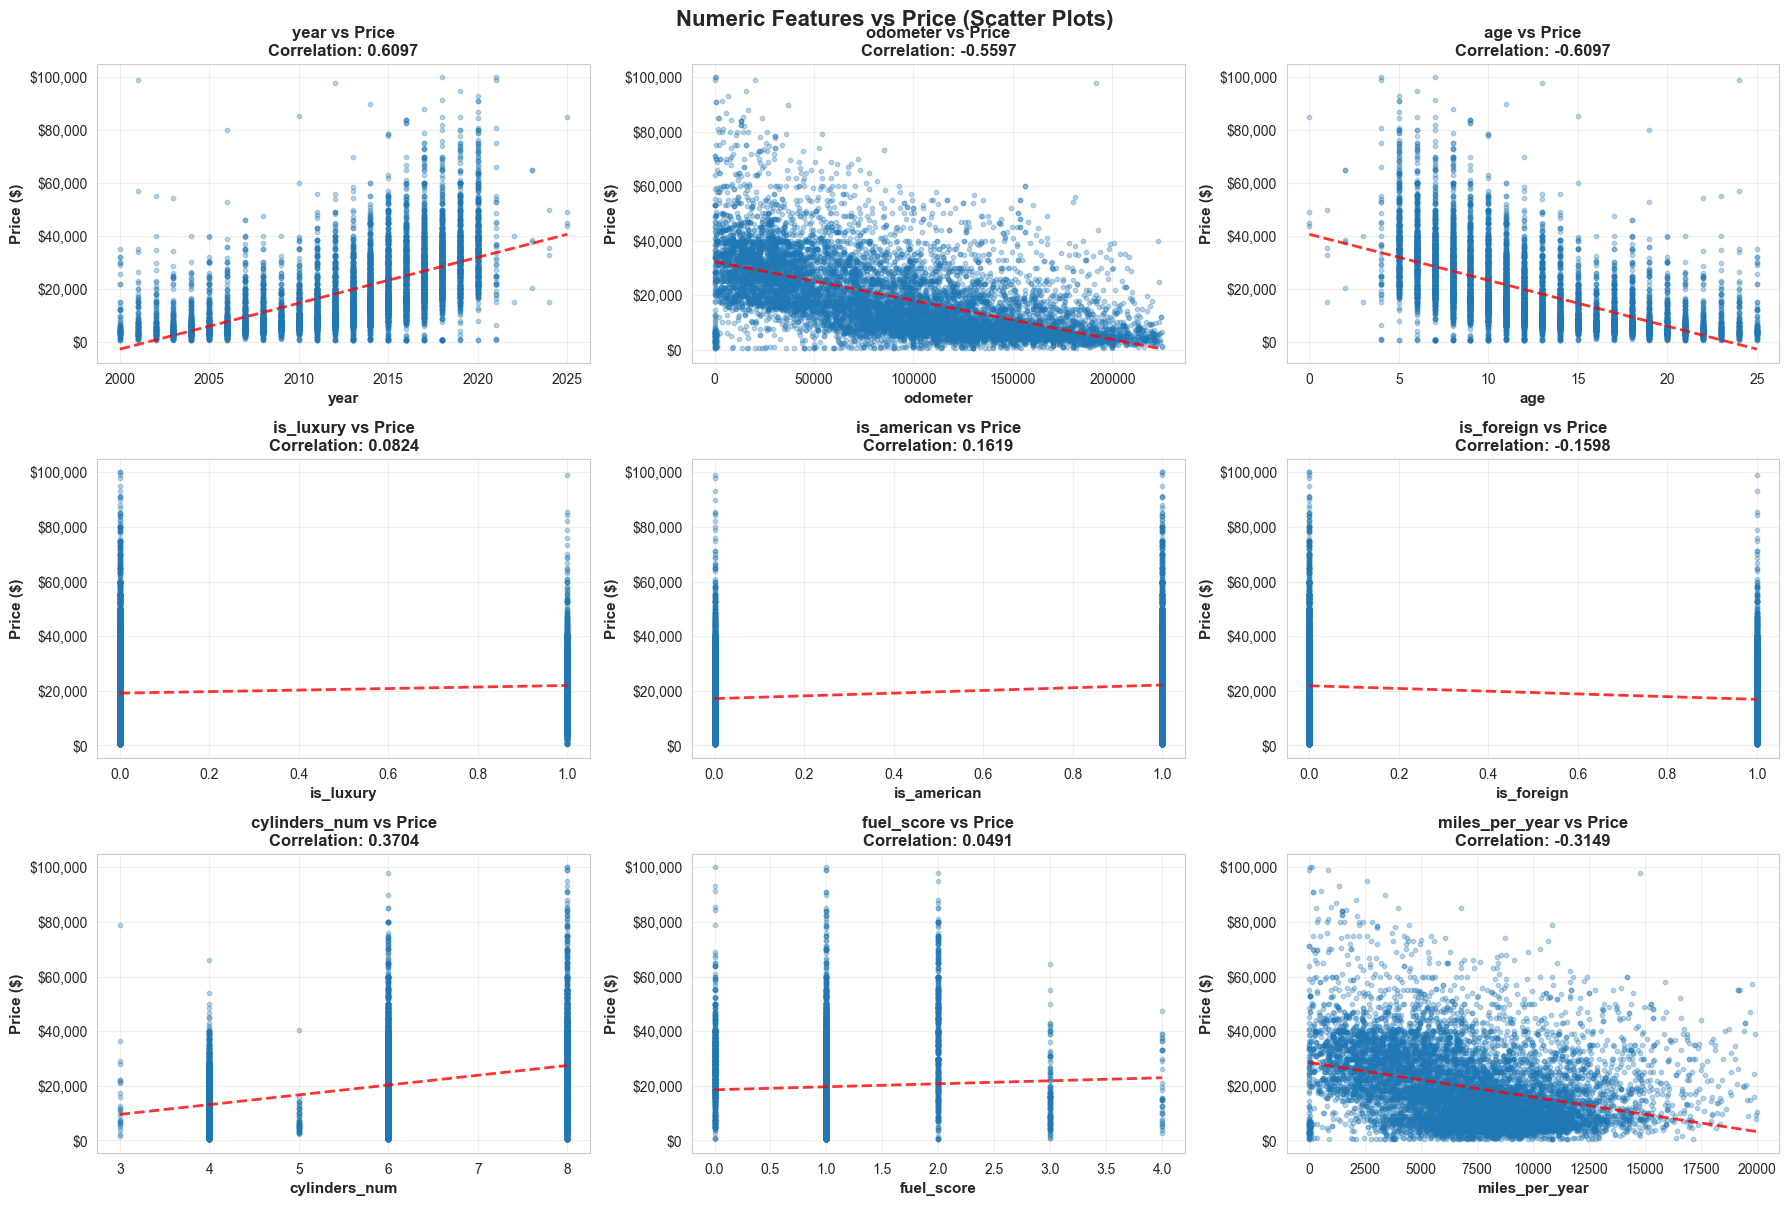


CORRELATION SUMMARY (Numeric Features)
year                :  0.6097  (Strong ↑ Positive)
cylinders_num       :  0.3704  (Moderate ↑ Positive)
is_american         :  0.1619  (Weak ↑ Positive)
is_luxury           :  0.0824  (Weak ↑ Positive)
fuel_score          :  0.0491  (Weak ↑ Positive)
is_foreign          : -0.1598  (Weak ↓ Negative)
miles_per_year      : -0.3149  (Moderate ↓ Negative)
odometer            : -0.5597  (Strong ↓ Negative)
age                 : -0.6097  (Strong ↓ Negative)


In [ ]:
# ============================================================
# SCATTER PLOTS: Each Numeric Feature vs. Price
# Purpose: Visualize the relationship between each numeric variable and price.
# The correlation coefficient (r) tells us:
#   - Positive correlation: As feature increases, price tends to increase
#   - Negative correlation: As feature increases, price tends to decrease
#   - Values close to 1 or -1 indicate strong relationships
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get all numeric columns (excluding price and id)
numeric_features = vehicles.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['price', 'id']]

print(f"Analyzing {len(numeric_features)} numeric features against price")
print(f"Features: {numeric_features}\n")

# Calculate number of rows needed for subplots
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

# Create scatter plot for each numeric feature vs price
for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Sample data for faster plotting (use all data if you want)
    sample_size = min(10000, len(vehicles))
    sample_df = vehicles.sample(n=sample_size, random_state=42)
    
    # Create scatter plot
    ax.scatter(sample_df[feature], sample_df['price'], alpha=0.3, s=10)
    
    # Calculate correlation
    corr = vehicles[[feature, 'price']].corr().iloc[0, 1]
    
    # Add trend line
    z = np.polyfit(sample_df[feature], sample_df['price'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample_df[feature].min(), sample_df[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
    
    # Labels and title
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} vs Price\nCorrelation: {corr:.4f}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Remove empty subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Numeric Features vs Price (Scatter Plots)', fontsize=16, fontweight='bold', y=1.001)
plt.show()

# Display correlation summary
print("\n" + "="*60)
print("CORRELATION SUMMARY (Numeric Features)")
print("="*60)
price_corr = vehicles[numeric_features + ['price']].corr()['price'].drop('price').sort_values(ascending=False)
for feature, corr_value in price_corr.items():
    direction = "↑ Positive" if corr_value > 0 else "↓ Negative"
    strength = "Strong" if abs(corr_value) > 0.5 else "Moderate" if abs(corr_value) > 0.3 else "Weak"
    print(f"{feature:20s}: {corr_value:7.4f}  ({strength} {direction})")
print("="*60)


In [ ]:
# ============================================================
# QUICK DATA PREVIEW
# Purpose: Visually inspect the first 25 rows of the cleaned dataset.
# Confirms that all transformations were applied correctly.
# ============================================================

vehicles.head(25)

,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,...,type,paint_color,state,age,is_luxury,is_american,is_foreign,cylinders_num,fuel_score,miles_per_year
0,7222695916,prescott,6000,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,Arizona,12.0,0,0,0,8.0,0,6785.056250
1,7218891961,fayetteville,11900,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,Arkansas,12.0,0,0,0,8.0,0,6785.056250
2,7221797935,florida keys,21000,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,Florida,12.0,0,0,0,8.0,0,6785.056250
3,7222270760,worcester / central MA,1500,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,Massachusetts,12.0,0,0,0,8.0,0,6785.056250
4,7210384030,greensboro,4900,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,North Carolina,12.0,0,0,0,8.0,0,6785.056250
5,7222379453,hudson valley,1600,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,New York,12.0,0,0,0,8.0,0,6785.056250
6,7221952215,hudson valley,1000,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,New York,12.0,0,0,0,8.0,0,6785.056250
7,7220195662,hudson valley,15995,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,New York,12.0,0,0,0,8.0,0,6785.056250
8,7209064557,medford-ashland,5000,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,Oregon,12.0,0,0,0,8.0,0,6785.056250
9,7219485069,erie,3000,2013.0,unknown,unknown,unknown,unknown,81420.675,unknown,...,unknown,unknown,Pennsylvania,12.0,0,0,0,8.0,0,6785.056250


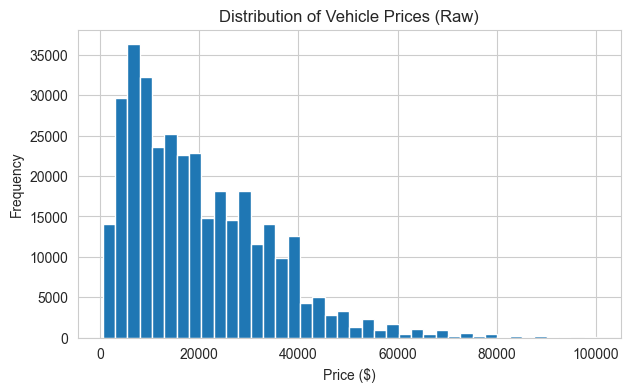

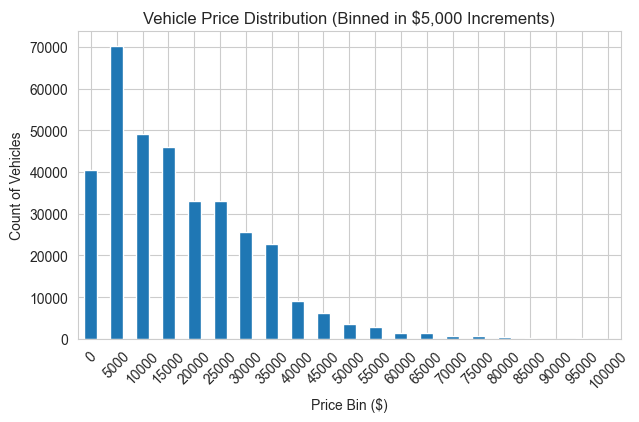

In [ ]:
# ============================================================
# PRICE DISTRIBUTION ANALYSIS
# Purpose: Understand how vehicle prices are distributed in our dataset.
# Key insight: Most cars cluster in lower price ranges (right-skewed distribution).
# The binned histogram groups prices into $5K buckets for easier interpretation.
# ============================================================

# Raw histogram showing all prices
plt.figure(figsize=(7,4))
vehicles['price'].hist(bins=40)
plt.title("Distribution of Vehicle Prices (Raw)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

# Binned version: Groups prices into $5,000 increments for clearer visualization
vehicles['price_bin_5k'] = (vehicles['price'] // 5000) * 5000

plt.figure(figsize=(7,4))
vehicles['price_bin_5k'].value_counts().sort_index().plot(kind='bar')
plt.title("Vehicle Price Distribution (Binned in $5,000 Increments)")
plt.xlabel("Price Bin ($)")
plt.ylabel("Count of Vehicles")
plt.xticks(rotation=45)
plt.show()

Correlation of all numeric features with price:

                   price
price           1.000000
year            0.609696
cylinders_num   0.370413
is_american     0.161909
is_luxury       0.082372
fuel_score      0.049109
id             -0.073008
is_foreign     -0.159770
miles_per_year -0.314882
odometer       -0.559660
age            -0.609696

Feature most correlated with price: year



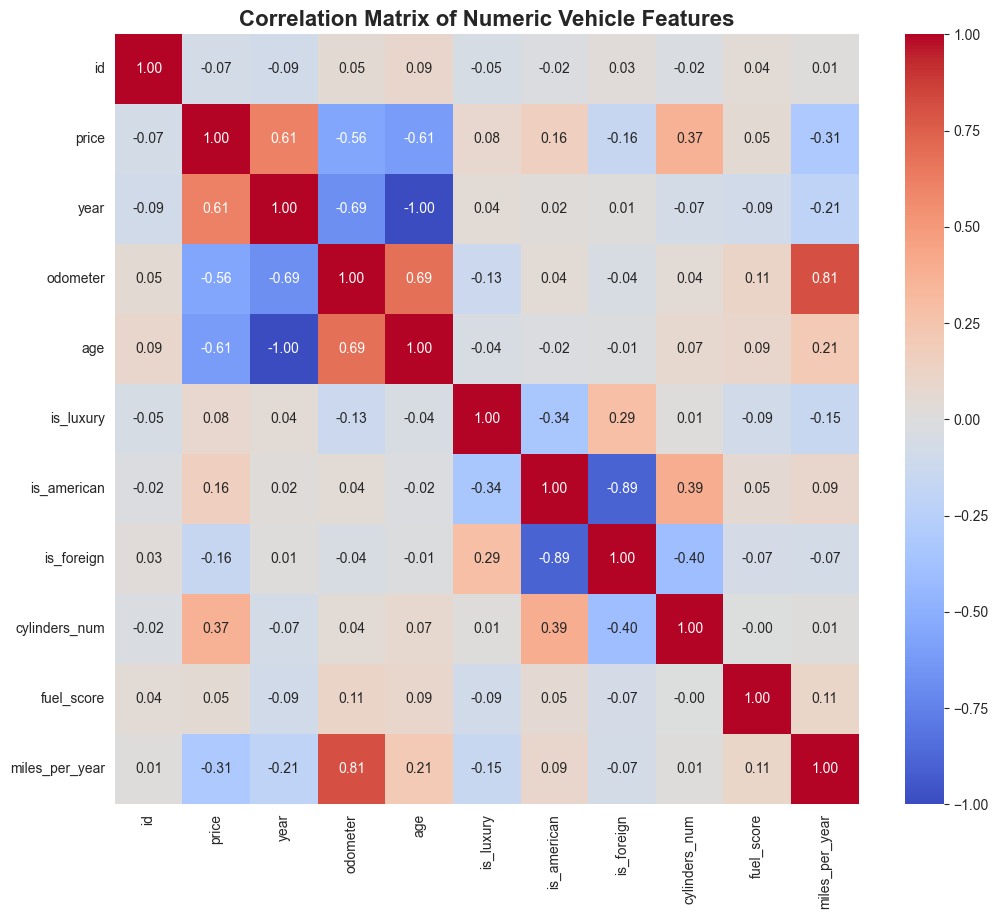

In [ ]:
# ============================================================
# CORRELATION MATRIX ANALYSIS
# Purpose: Identify which numeric features are most strongly related to price.
# The heatmap shows correlations between ALL numeric features:
#   - Red = positive correlation (both increase together)
#   - Blue = negative correlation (one increases, other decreases)
#   - White/pale = weak or no correlation
# Key findings: 'year' and 'age' have the strongest correlation with price.
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select only numeric features (exclude the binned price column)
numeric_vehicles = vehicles.select_dtypes(include=[np.number]).drop(
    columns=['price_bin_5k'], errors='ignore'
)

# 2. Calculate correlation matrix
correlation_matrix = numeric_vehicles.corr()

# 3. Extract and sort correlations with price
price_corr = correlation_matrix[['price']].sort_values(
    by='price', ascending=False
)
print("Correlation of all numeric features with price:\n")
print(price_corr)

# 4. Identify the strongest predictor (excluding price itself)
highest_corr_feature = (
    correlation_matrix[['price']]
    .nlargest(columns='price', n=2)
    .index[1]
)

print(f"\nFeature most correlated with price: {highest_corr_feature}\n")

# 5. Visual heatmap of all correlations
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, annot=True, 
    cmap='coolwarm', center=0, fmt=".2f"
)
plt.title("Correlation Matrix of Numeric Vehicle Features", fontsize=16, fontweight='bold')
plt.show()

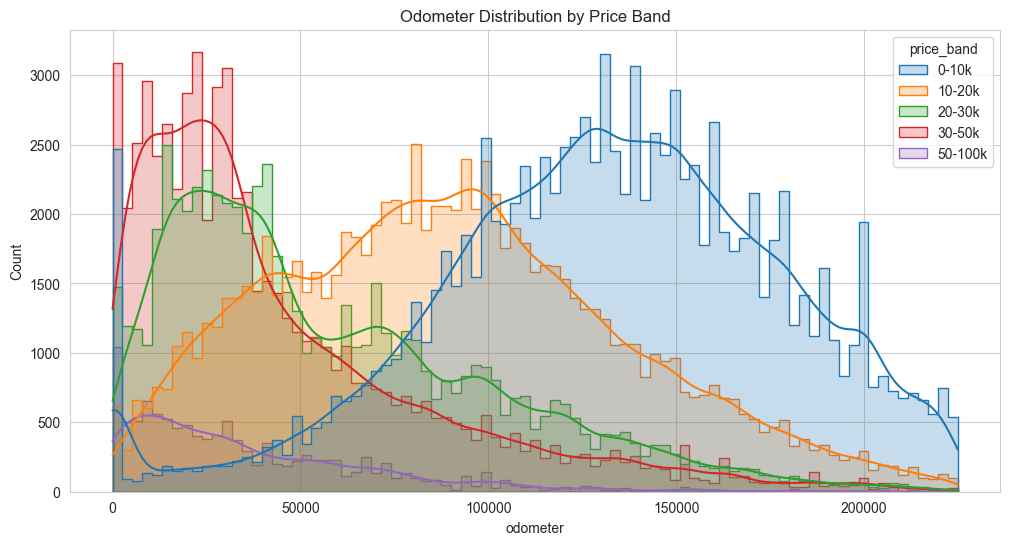

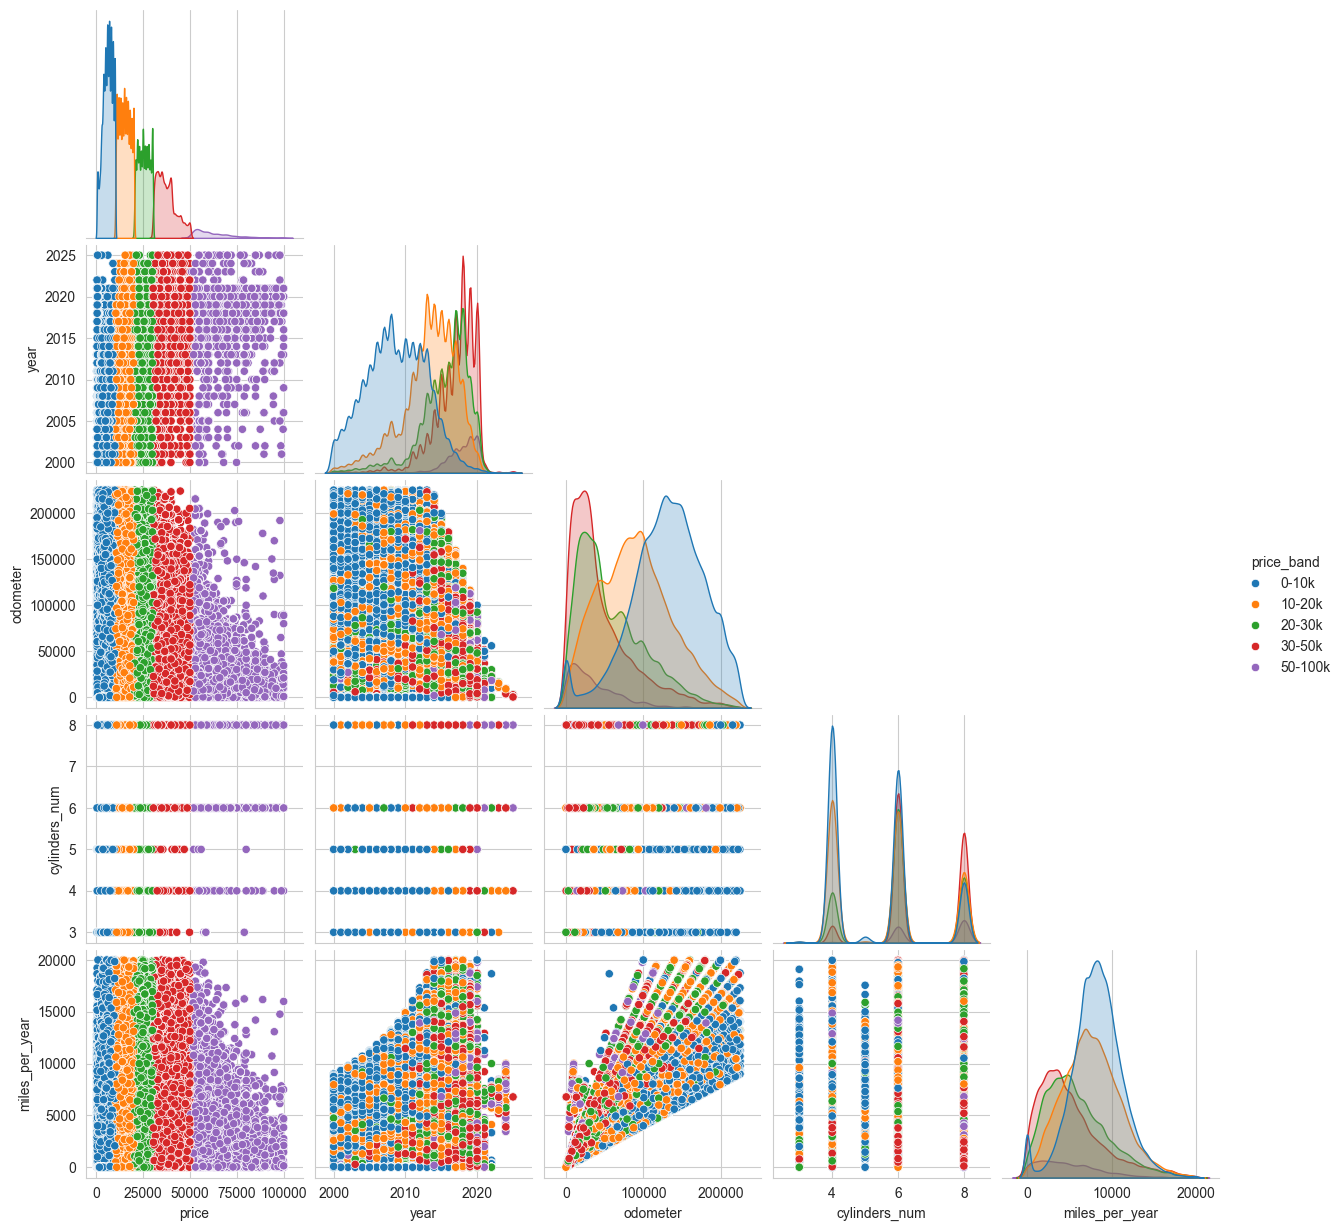

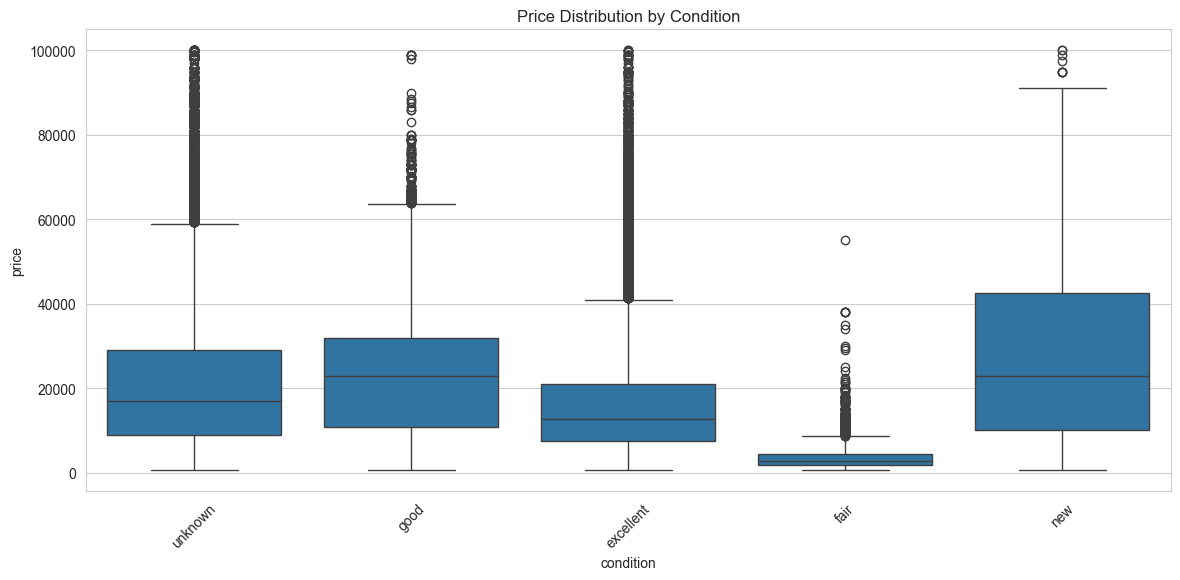

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# ============================================================
# MULTI-DIMENSIONAL VISUALIZATIONS
# Purpose: Explore relationships between features using price bands as categories.
# This reveals patterns that single-variable analysis might miss.
#
# What each visualization shows:
# 1. Histogram: How mileage varies across different price ranges
# 2. Pairplot: Relationships between multiple features simultaneously
# 3. Boxplot: How condition affects price (median, spread, outliers)
# 4-5. Interactive Plotly charts: Detailed exploration with trend lines
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

# Create price bands for categorical comparison
vehicles['price_band'] = pd.cut(
    vehicles['price'],
    bins=[0, 10000, 20000, 30000, 50000, 100000],
    labels=['0-10k', '10-20k', '20-30k', '30-50k', '50-100k']
)

# 1. Histogram: Mileage distribution colored by price band
plt.figure(figsize=(12,6))
sns.histplot(data=vehicles, x='odometer', hue='price_band', kde=True, element='step')
plt.title("Odometer Distribution by Price Band")
plt.show()

# 2. Pairplot: Multi-feature relationships at a glance
features = ['price', 'year', 'odometer', 'cylinders_num', 'miles_per_year', 'price_band']
sns.pairplot(vehicles[features], hue='price_band', diag_kind='kde', corner=True)
plt.show()

# 3. Boxplot: How vehicle condition affects price
plt.figure(figsize=(14,6))
sns.boxplot(data=vehicles, x='condition', y='price')
plt.title("Price Distribution by Condition")
plt.xticks(rotation=45)
plt.show()

# 4. Interactive scatter: Price vs Odometer with trend lines
fig = px.scatter(
    vehicles, x='odometer', y='price', color='price_band',
    trendline="ols", opacity=0.5
)
fig.update_layout(title="Price vs Odometer", title_x=0.5)
fig.show()

# 5. Interactive histogram: Miles per year distribution
fig = px.histogram(
    vehicles,
    x="miles_per_year",
    color="price_band",
    nbins=40,
    opacity=0.6
)
fig.update_layout(title="Miles per Year Distribution by Price Band", title_x=0.5)
fig.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# ============================================================
# MODEL PREPARATION: Define columns to exclude from features
# 'id' is just a unique identifier (not predictive)
# 'price' is our target variable (what we're predicting)
# ============================================================

drop_cols = ['id', 'price']

In [ ]:
# ============================================================
# SPLIT DATA INTO FEATURES (X) AND TARGET (y)
# X = All the information we use to make predictions
# y = The price we're trying to predict
# ============================================================

y = vehicles['price']
X = vehicles.drop(columns=drop_cols)

In [ ]:
# ============================================================
# DEFINE FEATURE GROUPS FOR PREPROCESSING
# Numeric features: Continuous values that need scaling (standardization)
# ============================================================

num_features = ['year', 'odometer', 'age', 'cylinders_num', 'miles_per_year']

In [ ]:
# ============================================================
# Binary/ordinal features: Already encoded as numbers (0/1 flags or scores)
# These still get scaled for consistency across models
# ============================================================

binary_features = ['is_luxury', 'is_american', 'is_foreign', 'fuel_score']

In [ ]:
# ============================================================
# Categorical features: Text-based columns requiring one-hot encoding.
# One-hot encoding creates a separate column for each unique value
# (e.g., 'fuel' becomes 'fuel_gas', 'fuel_diesel', 'fuel_electric', etc.)
# ============================================================

cat_features = [
    'region', 'manufacturer', 'model', 'condition',
    'fuel', 'title_status', 'transmission',
    'drive', 'type', 'paint_color', 'state'
]

In [ ]:
# ============================================================
# IMPORT PREPROCESSING TOOLS
# ColumnTransformer: Applies different transformations to different column groups
# StandardScaler: Normalizes numeric values to mean=0, std=1 (same scale)
# OneHotEncoder: Converts categories to binary columns
# ============================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
# ============================================================
# BUILD THE PREPROCESSOR
# This defines how to transform each type of column before modeling:
#   - 'num': Scale continuous features to standard range
#   - 'bin': Scale binary/ordinal features similarly
#   - 'cat': Convert text categories to numeric columns
# handle_unknown='ignore' ensures new categories during testing don't cause errors
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('bin', StandardScaler(), binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', ), cat_features)
    ]
)

In [ ]:
# ============================================================
# BASELINE MODEL: Linear Regression
# Purpose: Establish a performance baseline using the simplest regression model.
# Pipeline combines preprocessing + model into a single workflow.
# Cross-validation (cv=5): Tests the model on 5 different data splits for reliable results.
# MSE (Mean Squared Error): Average squared difference between predicted and actual prices.
#   Lower MSE = better predictions.
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr_pipe = Pipeline([('prep', preprocessor), ('model', LinearRegression())])

baseline_mse = -cross_val_score(lr_pipe, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
baseline_mse

np.float64(53662958.92091578)

In [ ]:
# ============================================================
# LASSO REGRESSION (L1 Regularization)
# Purpose: Linear regression with built-in feature selection.
# LASSO penalizes coefficients, pushing unimportant ones to exactly zero.
# This identifies which features actually matter for predicting price.
# Alpha: Controls penalty strength (higher = more features eliminated)
# GridSearchCV: Automatically finds the best alpha value.
# ============================================================

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_pipe = Pipeline([('prep', preprocessor), ('model', Lasso(max_iter=1000))])
lasso_params = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(lasso_pipe,lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X, y)

KeyboardInterrupt: 

In [ ]:
# ============================================================
# LASSO RESULTS: Best cross-validated MSE
# The negative sign is because sklearn maximizes scores internally,
# so we negate to get the actual MSE value.
# ============================================================

lasso_mse = -lasso_grid.best_score_
lasso_mse

In [ ]:
# ============================================================
# FEATURE IMPORTANCE FROM LASSO
# Purpose: Extract which features the model considers most important.
# Coefficients show the impact of each feature on price:
#   - Positive coef: Feature increases price
#   - Negative coef: Feature decreases price
#   - Zero coef: Feature was eliminated (not useful)
# We filter to non-zero coefficients and sort by absolute importance.
# ============================================================

best_lasso = lasso_grid.best_estimator_

feature_names = (best_lasso.named_steps['prep'].get_feature_names_out())
coefs = best_lasso.named_steps['model'].coef_
coef_df = (
    pd.DataFrame({'feature': feature_names, 'coef': coefs})
    .assign(abs_coef=lambda df: df.coef.abs())
    .query('abs_coef > 0')
    .sort_values('abs_coef', ascending=False)
)

coef_df.head(10)

In [ ]:
# ============================================================
# COUNT OF RETAINED FEATURES
# Shows how many features LASSO kept (non-zero coefficients).
# Fewer features = simpler, more interpretable model.
# ============================================================

len(coef_df)

In [ ]:
# ============================================================
# RIDGE REGRESSION (L2 Regularization)
# Purpose: Linear regression that shrinks coefficients toward zero.
# Unlike LASSO, Ridge keeps all features but reduces their impact.
# Better when many features contribute small amounts to the prediction.
# Alpha: Controls shrinkage strength (higher = more shrinkage)
# ============================================================

from sklearn.linear_model import Ridge

ridge_pipe = Pipeline([('prep', preprocessor), ('model', Ridge())])
ridge_params = {'model__alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X, y)
ridge_mse = -ridge_grid.best_score_

ridge_mse

In [ ]:
# ============================================================
# ELASTIC NET (Combined L1 + L2 Regularization)
# Purpose: Blends LASSO and Ridge approaches.
# l1_ratio: Balance between LASSO (1.0) and Ridge (0.0)
#   - 0.8 = mostly LASSO behavior (feature selection)
#   - 0.2 = mostly Ridge behavior (shrinkage)
# Useful when you want some feature selection but not as aggressive as pure LASSO.
# ============================================================

from sklearn.linear_model import ElasticNet

enet_pipe = Pipeline([('prep', preprocessor), ('model', ElasticNet(max_iter=1000))])
enet_params = {'model__alpha': [0.01, 0.1, 1], 'model__l1_ratio': [0.2, 0.5, 0.8]}
enet_grid = GridSearchCV(enet_pipe, enet_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
enet_grid.fit(X, y)
enet_mse = -enet_grid.best_score_

enet_mse

In [ ]:
# ============================================================
# K-NEAREST NEIGHBORS (KNN) REGRESSION
# Purpose: Predicts price based on similar vehicles in the dataset.
# Logic: "Find the K most similar cars and average their prices."
# Parameters:
#   - n_neighbors: How many similar cars to consider (5, 7, 11, or 15)
#   - weights='distance': Closer matches count more heavily
#   - p: Distance metric (1=Manhattan, 2=Euclidean)
# Non-linear approach that can capture complex relationships.
# ============================================================

from sklearn.neighbors import KNeighborsRegressor

knn_pipe = Pipeline([('prep', preprocessor),('model', KNeighborsRegressor())])
knn_params = {
    'model__n_neighbors': [5, 7, 11, 15],
    'model__weights': ['distance'],
    'model__p': [1, 2]
}

knn_grid = GridSearchCV(knn_pipe,knn_params,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
knn_grid.fit(X, y)
knn_mse = -knn_grid.best_score_

knn_mse

In [ ]:
# ============================================================
# MODEL COMPARISON SUMMARY
# Purpose: Compare all models side-by-side using MSE.
# Lower MSE = Better performance (more accurate price predictions)
# Sorted from best (lowest MSE) to worst (highest MSE).
# ============================================================

results = pd.DataFrame({
    'Model': ['Baseline Linear', 'Lasso', 'Ridge', 'ElasticNet', 'KNN'],
    'CV_MSE': [baseline_mse, lasso_mse, ridge_mse, enet_mse, knn_mse]}).sort_values('CV_MSE')

results

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.